# Minería de Datos (Master en Data Science, UIMP-UC)

## Predicción condicionada a clústering

### Rodrigo Manzanas   

## Introducción

En esta práctica vamos a utilizar el método *k-means* para realizar una predicción condicionada a tipos de tiempo (weather types en inglés, *WTs*), es decir a patrones atmosféricos característicos definidos como los centroides de un número determinado de clústers. Trabajaremos para ello con el dataset `meteo`, que ya ha sido utilizado en anteriores sesiones. Como sabes, la variable objetivo en este dataset es la precipitation diaria en Lisboa durante el período 1979-2008, y para predecirla se dispone de 320 predictores que describen la circulación atmosférica de larga escala. Dichos predictores corresponden a un conjunto de 8 variables meteorológicas en diferentes niveles verticales

* altura geopotencial en 500 hPa (Z500, columnas 2:41)
* temperatura en 850 hPa (T850, columnas 42:81), 700 hPa (T700, columnas 82:121), 500 hPa (T500, columnas 122:161) y en superficie (2T, columnas 162:201)
* humedad específica en 850 hPa (Q850, columnas 202:241) y 500 hPa (Q500, columnas 242:281)
* presión a nivel del mar (SLP, columnas 282:321)

definidas sobre un dominio geográfico que incluye 40 puntos (8 en la longitud y 5 en la latitud) sobre la península Ibérica.

Comenzamos cargando el dataset y separando el predictando (vector *y*) de los predictores (matriz *x*). Por conveniencia, renombraremos las columnas de *x* utilizando las etiquetas *Z500, T850, T700, T500, 2T, Q850, Q500* y *SLP*.

In [2]:
rm(list = ls())

## loading data
data = read.csv("meteo.csv")
y = data[, 2]  # predictand
x = data[, -c(1,2)]  # predictors: Z500,T850,T700,T500,2T,Q850,Q500,SLP
rm(data)

lon = seq(-10, 4, 2) # 2º resolution
lat = seq(36, 44, 2) # 2º resolution

## naming columns
colnames(x) = c(rep("Z500", length(lon)*length(lat)),
  rep("T850", length(lon)*length(lat)),
  rep("T700", length(lon)*length(lat)),
  rep("T500", length(lon)*length(lat)),
  rep("2T", length(lon)*length(lat)),
  rep("Q850", length(lon)*length(lat)),
  rep("Q500", length(lon)*length(lat)),
  rep("SLP", length(lon)*length(lat)))

Para familiarizarnos un poco más con el dataset, dibuja la climatología de cada una de las 8 variables predictoras. Puedes utilizar para ello la función *image.plot* del paquete *fields*.

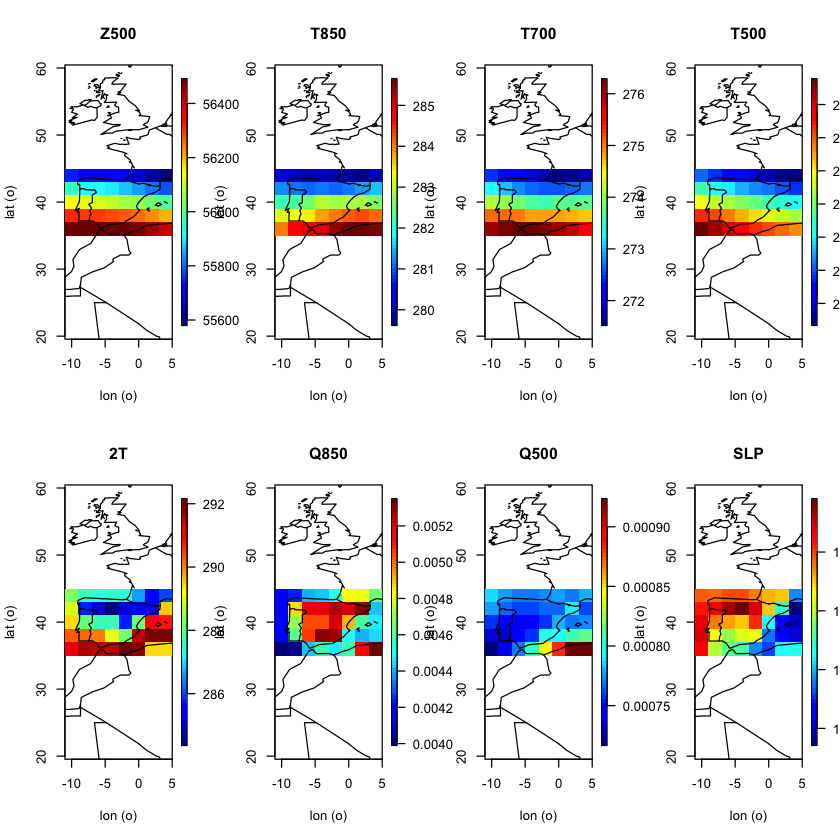

In [4]:
library(fields)
library(maps)
par(mfrow = c(2, 4))  # configuring figure layout
for (var in unique(colnames(x))) {
  image.plot(x = lon, y = lat, 
             z = matrix(colMeans(x[ , colnames(x) == var]), 
                          nrow = length(lon), 
                          ncol = length(lat),
                       byrow = TRUE),
             xlab = "lon (º)", ylab = "lat (º)", main = var,
            asp = 1)
  map(add = T)  # overlapping map
}

A continuación partiremos el dataset en train y test (75% y 25% de los datos, respectivamente), de forma aleatoria:

In [5]:
set.seed(555)

# train/test random splitting (75% and 25%, respectively)
n = length(y)
indtrain = sort(sample(n, round(0.75*n)))
indtest = setdiff(1:n, indtrain)

# 75% train
x.train = x[indtrain, ]
y.train = y[indtrain]

# 25% test
x.test = x[indtest, ]
y.test = y[indtest]

## k-NN (análogos, en meteorología)

### k-NN no condicionado
Comenzaremos nuestra práctica obteniendo la predicción para el período de test utilizando la técnica *k-NN*, considerando un único vecino (*1-NN*). Para ello, tendrás que utilizar la función *knn.reg* del paquete *FNN*.

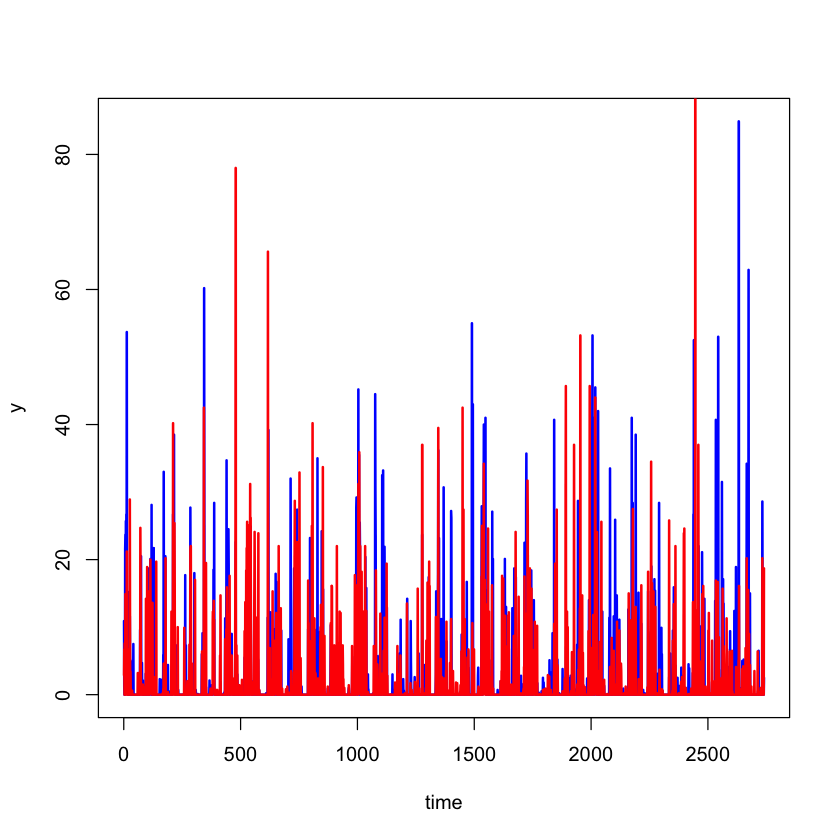

In [36]:
library(FNN)
## 1-NN prediction
knn = knn.reg(train=x.train, test=x.test, y=y.train, k=1)
predictiones = knn$pred

# plotting observed and predicted series
plot(y.test, type = "l", col = "blue", lwd = 2, xlab = "time", ylab = "y")
lines(predictiones, col = "red", lwd = 2)

Para validar esta predicción vamos a utilizar algunas de las métricas que hemos venido utilizando durante el curso, en particular el *accuracy* (tasa de aciertos) para la parte binaria lluvia/no lluvia y el RMSE, la correlación de Spearman y el ratio de varianzas para la parte continua. Consideremos *1mm* como umbral para discernir entre días secos y húmedos.

In [39]:
## validation
# accuracy (binary occurrence event)
acc.class = function(x, y) {
  stopifnot(length(x) == length(y))
  return(sum(diag(table(x, y))) / length(x))
}
# RMSE (continuous amount event)
rmse = function(x, y) {
sqrt(mean((x - y)^2))
}

Como se puede apreciar, los resultados son bastante buenos.

### k-NN condicionado a WTs
Veamos ahora qué sucedería al aplicar la misma técnica *1-NN* condicionada a un *k-means* con *k=10*. Ten en cuenta que la inicialización del *k-means* es aleatoria, por lo que conviene repetir el proceso de clustering un número de veces "razonablemente" alto, por ejemplo 20. Valida tu nueva predicción en función de las mismas métricas utilizadas en el ejemplo anterior.

In [41]:
set.seed(555)
## k-means with k=10
km10 = kmeans(x.train, 10, iter.max = 1000, nstart = 20)

## observed precipitation corresponding to the centroids
y.centroid = knn.reg(train = km10$centers, test = x.test, y = y.train, k = 1)

## 1-NN prediction
knn.km10 = knn.reg(train = km10$centers, test = x.test, y = y.centroid$pred, k = 1)

## validation
knn.km10.acc = acc.class(ifelse(y.test >= 1, 1, 0), ifelse(knn.km10$pred >= 1, 1, 0))
knn.km10.rmse = rmse(y.test, knn.km10$pred)
knn.km10.r = cor(y.test, knn.km10$pred, method = "spearman")
knn.km10.rv = var(knn.km10$pred) / var(y.test)
print(c(knn.km10.acc, knn.km10.rmse, knn.km10.r, knn.km10.rv))

[1]  0.2613139 12.0039861 -0.3771296  0.8165799


Los resultados son peores. ¿Puedes intuir por qué? Dibuja la predicción que acabas de obtener junto a la serie observada. ¿Qué observas?

[1] 3


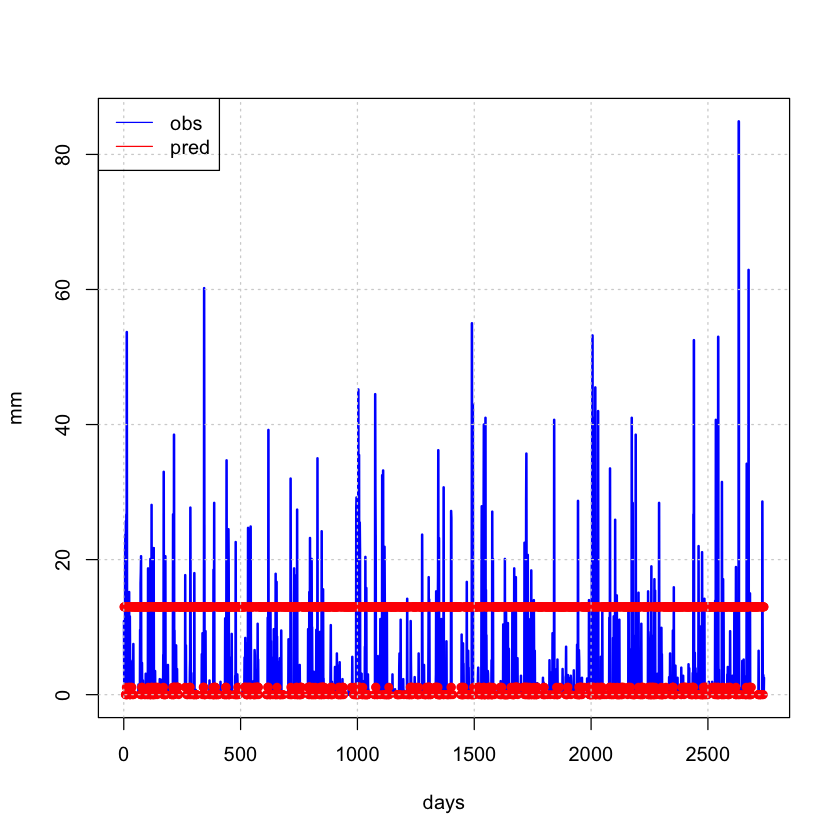

In [ ]:
# plotting observed and predicted series
plot(y.test, type = "l", lty = 1, col = "blue", lwd = 2, xlab = "days", ylab = "mm")
points(knn.km10$pred, pch = 16, col = "red")
grid()
legend("topleft", c("obs", "pred"), lty = 1, col = c("blue", "red"))

print(length(unique(knn.km10$pred)))

Repite el mismo proceso para *k=50*. A continuación, dibuja y valida la predicción obtenida. ¿Se aprecian diferencias?

[1]  0.4791971 12.2402133  0.1058588  2.1349557
[1] 22


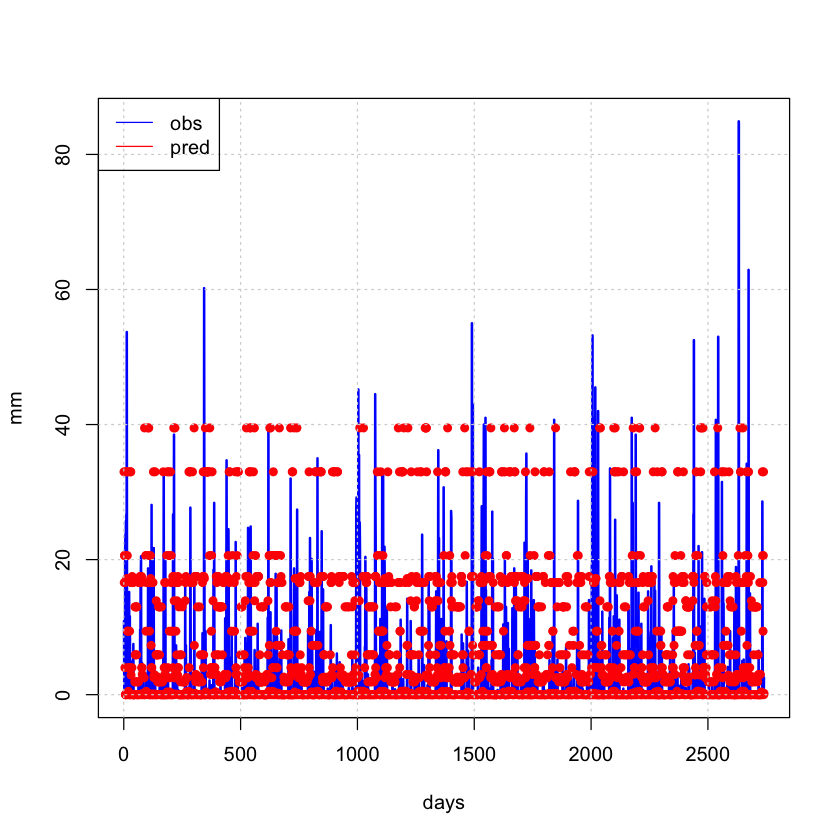

In [34]:
set.seed(555)
## k-means with k=10
km50 = kmeans(x.train, 50, iter.max = 1000, nstart = 20)

## observed precipitation corresponding to the centroids
y.centroid = knn.reg(train = km50$centers, test = x.test, y = y.train, k = 1)

## 1-NN prediction
knn.km50 = knn.reg(train = km50$centers, test = x.test, y = y.centroid$pred, k = 1)

## validation
knn.km50.acc = acc.class(ifelse(y.test >= 1, 1, 0), ifelse(knn.km50$pred >= 1, 1, 0))
knn.km50.rmse = rmse(y.test, knn.km50$pred)
knn.km50.r = cor(y.test, knn.km50$pred, method = "spearman")
knn.km50.rv = var(knn.km50$pred) / var(y.test)
print(c(knn.km50.acc, knn.km50.rmse, knn.km50.r, knn.km50.rv))

## plotting
plot(y.test, type = "l", lty = 1, col = "blue", lwd = 2, xlab = "days", ylab = "mm")
points(knn.km50$pred, pch = 16, col = "red")
grid()
legend("topleft", c("obs", "pred"), lty = 1, col = c("blue", "red"))

print(length(unique(knn.km50$pred)))

Como sabes, el método *k-means* puede resultar poco conveniente cuando no se tiene una idea a priori sobre el número de clústers (*k*) que se necesitan para caracterizar adecuadamente el dataset. Por tanto, vamos a realizar un estudio de sensibilidad a este factor repitiendo la predicción *1-NN*, y su correspondiente validación, para distintos *k* desde 10 hasta 300, en intervalos de 50. Mide el tiempo que se emplea en dicho proceso (puedes utilizar la función *Sys.time()*).

In [43]:
## k-means with varying k
t1 = Sys.time()
val = c()  # initializing validation matrix 
nclus = seq(10, 300, 50)
for (k in nclus) {
    print(paste("... k =", k, "..."))
    
    set.seed(555)
    km = kmeans(x.train, k, iter.max = 1000, nstart = 20)

    # observed precipitation corresponding to the centroids
    y.centroid = knn.reg(train = km$centers, test = x.test, y = y.train, k = 1)

    ## 1-NN prediction
    knn.km = knn.reg(train = km$centers, test = x.test, y = y.centroid$pred, k = 1)
    
    knn.km.acc = acc.class(ifelse(y.test >= 1, 1, 0), ifelse(knn.km$pred >= 1, 1, 0))
    knn.km.rmse = rmse(y.test, knn.km$pred)
    knn.km.r = cor(y.test, knn.km$pred, method = "spearman")
    knn.km.rv = var(knn.km$pred) / var(y.test)

    val = cbind(val, c(knn.km.acc, knn.km.rmse, knn.km.r, knn.km.rv))
}
t2 = Sys.time()
print(t2 - t1)

[1] "... k = 10 ..."
[1] "... k = 60 ..."
[1] "... k = 110 ..."
[1] "... k = 160 ..."
[1] "... k = 210 ..."
[1] "... k = 260 ..."
Time difference of 1.29312 mins


Plotea los resultados de la validación para cada métrica, en función del número de clústers considerado:

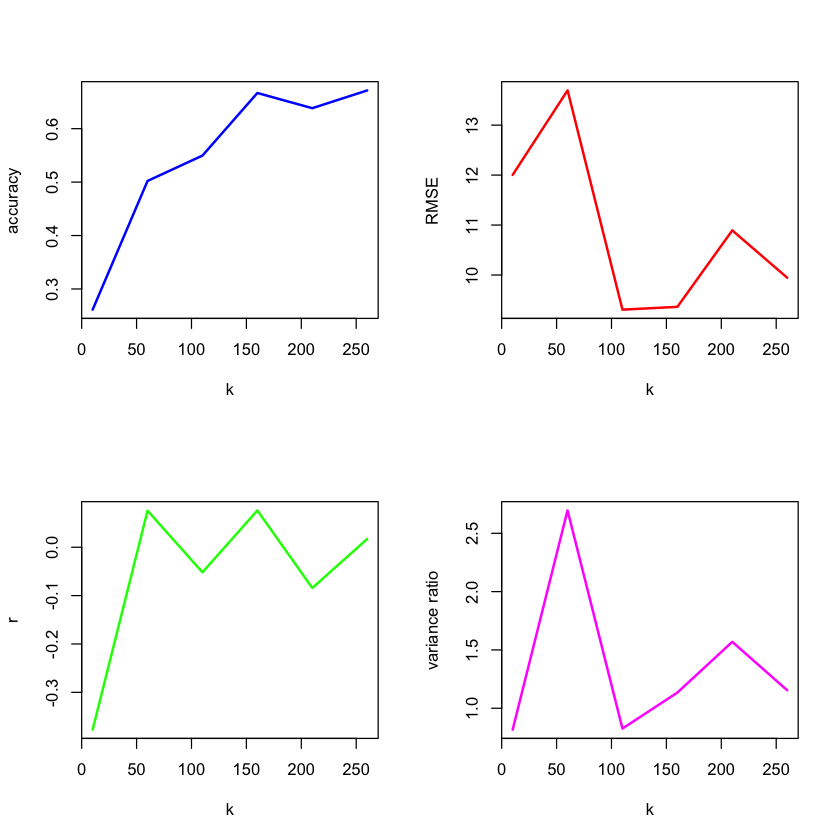

In [47]:
# plotting
par(bg = "white", mfrow = c(2, 2))
plot(nclus, val[1, ], type = "l", col = "blue", lwd = 2, xlab = "k", ylab = "accuracy")
plot(nclus, val[2, ], type = "l", col = "red", lwd = 2, xlab = "k", ylab = "RMSE")
plot(nclus, val[3, ], type = "l", col = "green", lwd = 2, xlab = "k", ylab = "r")
plot(nclus, val[4, ], type = "l", col = "magenta", lwd = 2, xlab = "k", ylab = "variance ratio")

En principio, el mayor efecto de la elección del número de clústers se da sobre la correlación y el ratio de varianzas, sin embargo, los resultados son en general muy inestables, por lo que la elección del *k* "óptimo" no es para nada trivial.

Hasta ahora hemos experimentando con clústers "arbitrarios". Sin embargo, vamos a ver que para ciertos valores de *k*, el clústering al que se llega ofrece cierta interpretabilidad. Por ejemplo, si escogemos un *k=4*, los clústers resultantes podrían identificarse con las estaciones del año. Para comprobarlo, dibuja la climatología observada para la temperatura en superficie (2T) en los 4 clústers.

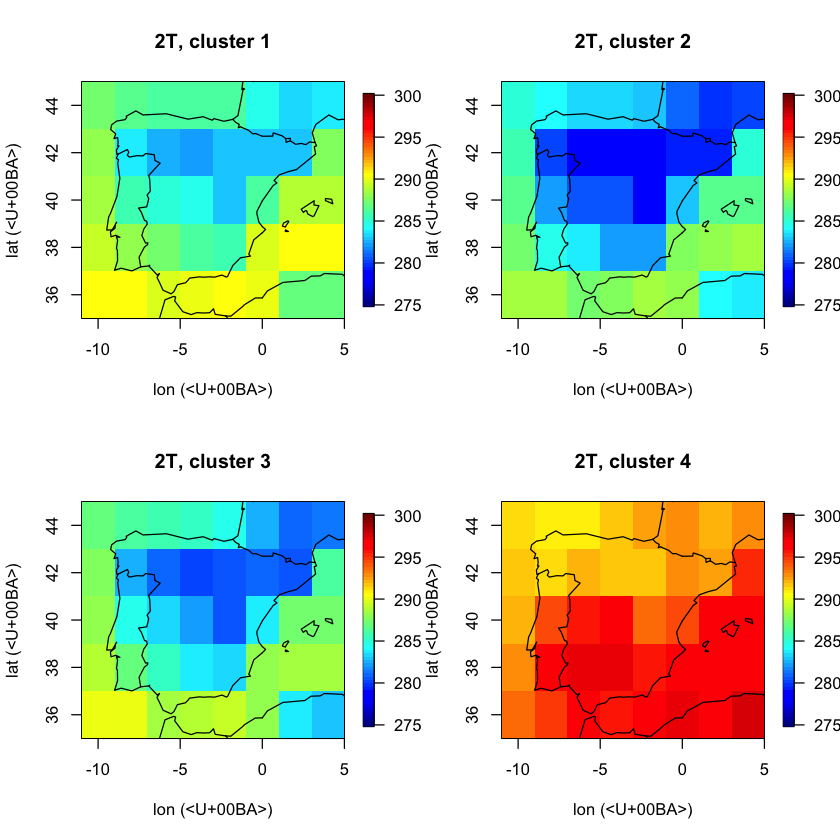

In [46]:
## k-means with k=4
set.seed(555)
km = kmeans(x.train, 4, iter.max = 1000, nstart = 20)

## climatology for 2T in each cluster
par(mfrow = c(2, 2))
for (iclus in 1:4) {
  z = colMeans(x.train[km$cluster == iclus, colnames(x) == "2T"])  
  image.plot(x = lon, y = lat, 
             z = matrix(z, 
                          nrow = length(lon), 
                          ncol = length(lat),
                       byrow = TRUE),
             zlim = c(275, 300),
             xlab = "lon (º)", ylab = "lat (º)", 
             main = paste("2T, cluster",iclus))
  map(add = T)
}

Efectivamente, se pueden identificar las 4 estaciones del año. Comprobemos qué resultados se obtendrían condicionando el método *1-NN* a un *k-means* con 4 WTs.

In [48]:
set.seed(555)
# k-means with k=4
km4 = kmeans(x.train, 4, iter.max = 1000, nstart = 20)

# observed precipitation corresponding to the centroids
y.centroid = knn.reg(train = km4$centers, test = x.test, y = y.train, k = 1)

# 1-NN prediction
knn.km4 = knn.reg(train = km4$centers, test = x.test, y = y.centroid$pred, k = 1)

##validation   
knn.km4.acc = acc.class(ifelse(y.test >= 1, 1, 0), ifelse(knn.km4$pred >= 1, 1, 0))
knn.km4.rmse = rmse(y.test, knn.km4$pred)
knn.km4.r = cor(y.test, knn.km4$pred, method = "spearman")
knn.km4.rv = var(knn.km4$pred) / var(y.test)


Warning message in cor(y.test, knn.km4$pred, method = "spearman"):
"the standard deviation is zero"


**Pregunta:** Más allá de incrementar el número de clústers, ¿se te ocurre alguna otra estrategia para aliviar el desplome del ratio de varianzas?

Una vez hecho el *4-means* habrá que identificar, para cada día del test, cuál de los centroides que has obtenido es el más parecido al patrón atmosférico del día en cuestión.

**Pista:** Puedes usar la función *dist*, que te permitirá calcular la distancia euclídea entre patrones atmosféricos.

In [ ]:
set.seed(555)
## k-means with k=4
km = kmeans(x.train, 4, iter.max = 1000, nstart = 20)
## distances, for each day in test, to each of the 4 centroids
dist.euc = as.matrix(dist(rbind(km$centers, x.test), method = "euclidean"))
## extracting submatrix of interest
dist.euc = dist.euc[-seq(1:4), 1:4]  
## vector indicating, for each day in test, the nearest centroid
clus = apply(dist.euc, 1, "which.min")

A continuación, se trata de utilizar tan sólo los días (del train) que caen dentro del clúster representado por dicho centroide para ajustar un modelo estocástico, que constará de dos pasos. Primero, se calcula la probabilidad de lluvia en ese clúster (*p.rain*). Seguidamente, se trata de ajustar los parámetros de una función Gamma (*shape* y *rate*) a partir de los días de lluvia del clúster (necesitarás para ello la función *fitdist* del paquete *fitdistrplus*). Finalmente, a partir de los parámetros *p.rain*, *shape* y *scale* se simulará un valor predicho para ese día concreto del test.

In [ ]:
library(fitdistrplus)
## obtaining p.rain, shape and rate for each cluster
p.rain.clus = c()  
shape.clus = c()
rate.clus = c()
for (iclus in sort(unique(clus))) {
  ind.train = which(km$cluster == iclus)  # days (in train) within target cluster
 
  # rain probability and Gamma parameters (fitted within target cluster)

}

## generating stochastic prediction for each day in test
pred = c()
#for (iday in 1:nrow(x.test)) {
  # p.rain, shape and scale parameters used to generate a predicted value for that day in test  

    # simulating a predicted value (stochastically)  
  #if (runif(1) < p.rain) {
    
  #} else {
    
  #}
#}

## validation


Como puedes ver, el ratio de varianzas ha mejorado notablemente. Sin embargo, como consecuencia del proceso de estocastización, la correlación ha bajado.

## Modelos lineales generalizados (GLMs):

Pasemos ahora a utilizar GLMs para abordar nuestro problema, la predicción de lluvia diaria en Lisboa. Dado el carácter mixto (discreto/continuo) de esta variable, habrá que realizar el proceso en dos pasos: en primer lugar se estimará la ocurrencia y a continuación la cantidad. Para ello, consideraremos la familia `binomial` con función de enlace `logit` (regresión logística) para el evento binario "ocurrencia de lluvia" y la familia `Gamma` con función de enlace `log` para el evento continuo "cantidad de lluvia".

### GLM no condicionado
Comencemos construyendo el GLM de ocurrencia, basándonos para ello en los campos crudos (las 320 variables predictoras de que disponemos) en el período de train.

In [ ]:
# binary occurrence
occ = y
occ = ifelse(occ >= 1, 1, 0)

## data frame for occurrence
df.occ = data.frame(y.occ = occ, predictors = x)

## GLM for occurrence (logistic regression in train period)


Una vez hemos ajustado el modelo, lo utilizamos para predecir en el test. Tenemos que convertir la predicción probabilística obtenida en binaria (considera para ello un umbral 0.5).

In [ ]:
## occurrence prediction for test


A continuación, construiremos el GLM para la cantidad. Para su ajuste, tenemos que seleccionar previamente, dentro del train, los días de lluvia (la familia Gamma sólo acepta valores positivos). 

In [ ]:
## data frame for amount
df.amo = data.frame(y.amo = y, predictors = x)

## selecting rainy days
indrain = which(y > 1)

## GLM for amount


Y utilizamos el modelo para predecir en el test.

In [ ]:
## amount prediction for test


Llegados a este punto, multiplicaremos las predicciones de ocurrencia y cantidad obtenidas para el test y validaremos la serie resultante, utilizando las mismas métricas de validación que empleamos para el caso de la técnica *k-NN*.

In [ ]:
## validation (for test)


Compara estos resultados con los que se obtuvieron para el método *1-NN* (no condicionado).

### GLM condicionado a WTs
A continuación, similarmente a como hicimos con la técnica k-NN, vamos a condicionar la predicción con GLMs a un clustering sobre tipos de tiempo. Empecemos por un *k-means* con 4 tipos de tiempo. Para ello, una vez hecho el *4-means*, tendrás que identificar, para cada día del test, cuál de los centroides que has obtenido es el más parecido al patrón atmosférico del día en cuestión. A continuación, tendrás que ajustar los dos GLM (ocurrencia y cantidad) utilizando tan sólo los días (del train) que caen dentro del clúster representado por dicho centroide.

In [ ]:
set.seed(555)
## k-means with k=4
km = kmeans(x.train, 4, iter.max = 1000, nstart = 20)
## distances, for each day in test, to each of the 4 centroids
dist.euc = as.matrix(dist(rbind(km$centers, x.test), method = "euclidean"))
## extracting submatrix of interest
dist.euc = dist.euc[-seq(1:4), 1:4]  
## vector indicating, for each day in test, the nearest centroid
clus = apply(dist.euc, 1, "which.min")

pred = c()  # initializing prediction vector
#for (iclus in sort(unique(clus))) {
  #print(paste("... cluster", iclus, "..."))
  
  # days (in train) within target cluster
  
  # days (in test) whose atmospheric pattern corresponds to the target cluster
  
  ## GLM for occurrence (fitted within target cluster)
  
  ## GLM for amount (fitted within target cluster)
  
  ## complete prediction, properly placed 
  
#}

Han salido muchos "warnings", ¿intuyes a qué pueden deberse? Dibuja la serie predicha que has obtenido, ¿qué observas?

In [ ]:
plot(pred, type = "l", xlab = "days", ylab = "mm")
grid()

Fíjate que, debido al condicionamiento al clústering, disminuye el número de observaciones que se utilizan en los ajustes, por lo que el efecto de la colinealidad en los predictores se torna más relevante. Como consecuencia, es frecuente encontrarse en este tipo de situaciones con GLMs que no han podido ajustarse bien y pueden dar lugar a NAs o a outliers (valores de precipitación anómalamente altos), que hay que eliminar. Para ello se pueden considerar distintos criterios (todos ellos, hasta cierto punto, arbitrarios), tales como deshacerse de los valores que superen un determinado número de veces el valor máximo observado. Nosotros, en este ejemplo, eliminaremos todos los valores predichos que se sitúen tres veces por encima del percentil 99 observado.

In [ ]:
pred[pred > quantile(y.test, 0.99)*3] = NA   # removing outliers
plot(pred, type = "l", xlab = "days", ylab = "mm")
grid()

In [ ]:
## validation


Compara estos resultados con los que obtuviste para el GLM no condicionado. ¿Qué conclusiones obtienes?

Para finalizar la práctica, repite el experimento anterior (GLM condicionado a clústering) para un número alto de tipos de tiempo, por ejemplo 100. ¿Qué sucede?  
**Pregunta:** ¿Por qué?

In [ ]:
set.seed(555)
## k-means with k=100

## distances, for each day in test, to each of the 100 centroids

## extracting submatrix of interest

## vector indicating, for each day in test, the nearest centroid

pred = c()  # initializing prediction vector
#for (iclus in sort(unique(clus))) {
  #print(paste("... cluster", iclus, "..."))
  
  # days (in train) within target cluster
  # days (in test) whose atmospheric pattern corresponds to the target cluster
  
  ## GLM for occurrence (fitted within target cluster)
  
  ## GLM for amount (fitted within target cluster)
  
  ## complete prediction, properly placed 
  
#}

**Pregunta:** ¿Qué se te ocurre para solucionar este problema? 
Intenta solventar esta limitación y valida la predicción que obtienes con *k=100*. ¿Qué resultados obtienes?

In [ ]:
## avoiding errors

In [ ]:
## removing outliers and plotting
